In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import os
import random
from collections import defaultdict
from PIL import Image
from torch.utils.data import DataLoader, Dataset


random.seed(0) #for reproducibility

In [2]:
class Market1501(Dataset):
    def __init__(self, root="../data/Market-1501/", train=True,
                 transform=None, target_transform=None):
        """Treats the test and query folders as training and the train folder as test."""
        self.are_we_training = train
        self.root = root
        self.label_to_start_stop_idxs = defaultdict(list)
       # self.idx_to_label = defaultdict(lambda : -1)
        #self.labels_to_idxs = defaultdict(list)
        self.labels = []
        self.idx_to_label = {}
        
        self.transform = transform
        self.target_transform = target_transform
        
        #NOTE TEST, TRAIN here are not the same as our val/train.
        self._TEST_FOLDER = os.path.join(self.root, "bounding_box_test")
        self._QUERY_FOLDER = os.path.join(self.root, "query")
        self._TRAIN_FOLDER = os.path.join(self.root, "bounding_box_train")
        
        if self.are_we_training:
            
            self.filenames = []
            #self.curr_idx = 0
            test_box_filenames = os.listdir(self._TEST_FOLDER)
            query_filenames = os.listdir(self._QUERY_FOLDER)
            
            
            #ignore junk/distraction files
            test_box_filenames = test_box_filenames[6617:] 
            
            #ignore thumbs.db
            test_box_filenames = test_box_filenames[:-1]
            query_filenames = query_filenames[:-1]
            
            self.label_to_filenames = defaultdict(list) #label -> list of filenames
            
            #we have label_to_filename[label] = [filename, filename, ...]
            latest_label_seen = -1
            
            #we want to have all the elements with the same label occur together
            #so we fiddle around a bit to make that happen
            for filename in test_box_filenames:
                full_filename = os.path.join(self._TEST_FOLDER, filename)
                label = int(filename[:4])
                self.label_to_filenames[label].append(full_filename)
                if label > latest_label_seen: #new label
                    self.labels.append(label)
                    latest_label_seen = label
                
            for filename in query_filenames:
                full_filename = os.path.join(self._QUERY_FOLDER, filename)
                label = int(filename[:4])
                self.label_to_filenames[label].append(full_filename)
                
            idx = 0
            for label in self.labels:
                start_idx = idx 
                for filename in self.label_to_filenames[label]:
                    self.filenames.append(filename)
                    self.idx_to_label[idx] = label
                    idx += 1
                end_idx = idx - 1
                self.label_to_start_stop_idxs[label] = [start_idx, end_idx]
            
        else:
            self.filenames = []
            
            #ignore thumbs.db
            train_filenames = os.listdir(self._TRAIN_FOLDER)[:-1]
            
            latest_label_seen = 2
            self.label_to_start_stop_idxs[latest_label_seen].append(0)
            self.labels = [2]
            for i,filename in enumerate(train_filenames):
                full_filename = os.path.join(self._TRAIN_FOLDER, filename)
                self.filenames.append(full_filename)
                label = int(filename[:4])
                self.idx_to_label[i] = label
                if label > latest_label_seen:
                    self.label_to_start_stop_idxs[latest_label_seen].append(i-1)
                    latest_label_seen = label
                    self.label_to_start_stop_idxs[label] = [i]
                    self.labels.append(label)
            #boundary case: the last label won't have an end point
            self.label_to_start_stop_idxs[latest_label_seen].append(len(train_filenames) - 1)
            
        #self.labels_inv[self.labels[i]] = i
        self.labels_inv = {x : i for (i,x) in enumerate(self.labels)}
                    
    
    def __getitem__(self, idx):
        #we will get the image from self.filenames[i]
        img = Image.open(self.filenames[idx]).convert("RGB")
        
        #use labels_inv to get labels between 0 and N-1
        #instead of 1, 4, 7, ...
        label = self.labels_inv[self.idx_to_label[idx]]
        
        if self.transform is not None:
            img = self.transform(img)
            
        if self.target_transform is not None:
            label = self.target_transform(label)
        
        return img, label
    
    def __len__(self):
        return len(self.filenames)
        

In [3]:
l = os.listdir("../data/Market-1501/bounding_box_test/")
m = os.listdir("../data/Market-1501/query/")
n = os.listdir("../data/Market-1501/bounding_box_train/")

In [4]:
len(l), len(m), len(n)

(19733, 3369, 12937)

In [5]:
l[6616], l[6617]

('0000_c6s4_012502_10.jpg', '0001_c1s1_001051_03.jpg')

In [6]:
query_plus_test = 19733 - 6617 + 3369
query_plus_test #since more query + test than number of training, we use it as train instead

16485

In [7]:
l[-2], m[-2]

('1501_c6s4_001902_01.jpg', '1501_c6s4_001877_00.jpg')

#### **Testing Dataset**

In [8]:
dataset = Market1501(train=True)

label = 1


type(img) = <class 'PIL.Image.Image'>


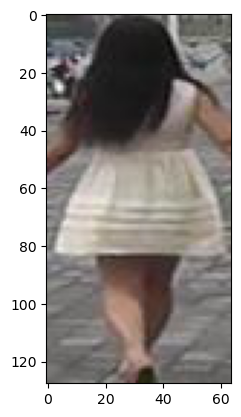

In [9]:
img, label = dataset[0]
print(f"label = {label}\n\n")
print(f"type(img) = {type(img)}")
#print(f"img has shape {img.shape}\n\n")


plt.imshow(img)
plt.show()

In [10]:
len(dataset)

16483

In [11]:
dataset.label_to_start_stop_idxs[3]

[65, 79]

In [12]:
[dataset.idx_to_label[i] for i in range(65, 80)]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [13]:
dataset.idx_to_label[79]

3

label = 2


type(img) = <class 'PIL.Image.Image'>


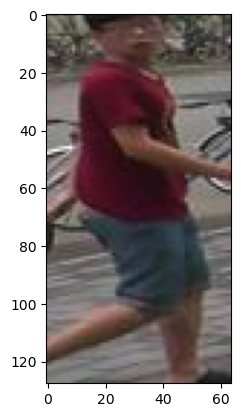

In [14]:
dataset = Market1501(train=False)
img, label = dataset[0]
print(f"label = {label}\n\n")
print(f"type(img) = {type(img)}")
#print(f"img has shape {img.shape}\n\n")


plt.imshow(img)
plt.show()

In [15]:
dataset.label_to_start_stop_idxs[dataset.labels[0]]

[0, 45]

In [16]:
[dataset.idx_to_label[i] for i in range(0,46)]

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [18]:
from src.data_tools.UniformSampler import ClassUniformBatchSampler

ModuleNotFoundError: No module named 'src'

In [ ]:
train_loader = torch.utils.data.DataLoader()